# EECS 731 Final Project - Clothing One
## Classification

In [156]:
import pandas as pd
import pickle

In [157]:
reviews = pickle.load(open("../Data/reviews.pkl", "rb" ))
rented_for_encoding = pickle.load(open("../Data/rented_for_encoding.pkl", "rb"))
body_type_encoding = pickle.load(open("../Data/body_type_encoding.pkl", "rb"))
category_encoding = pickle.load(open("../Data/category_encoding.pkl", "rb"))

In [158]:
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2


In [159]:
rented_for_encoding.head()

,encoding
labels,
date,0
everyday,1
formal affair,2
other,3
party,4


In [160]:
body_type_encoding.head()

,encoding
labels,
apple,0
athletic,1
full bust,2
hourglass,3
pear,4


In [161]:
category_encoding.head()

,encoding
labels,
ballgown,0
blazer,1
blouse,2
blouson,3
bomber,4


## Scenario:
* User is looking at a product or has a product in their cart. We take the user's body type and get a cluster similar to it.

* Cluster people by body features, then filter by occassion

* Could look at most common items for a specific occasion

* Come up with a score combining date (recent better), rating, and percentage of users who said item fit


### Other Notes
* Do an elbow chart

In [173]:
userDetails = reviews[['age', 'body_type','height','weight', 'user_id']].copy()
#add weight to the body_type by creating another column and cubing it - CONSIDER REMOVING THIS
userDetails['body_type_weighted'] = userDetails['body_type'].copy()**3

print('userDetails Length: ' + str(len(userDetails)))
userDetails.head()

userDetails Length: 146381


,age,body_type,height,weight,user_id,body_type_weighted
0,28,3,68.0,137,420272,27
1,36,6,66.0,132,273551,216
2,34,4,65.0,135,909926,64
3,27,1,69.0,145,151944,1
4,45,1,68.0,138,734848,1


In [213]:
userDetailsNoDuplicates = userDetails.drop_duplicates(keep = 'first').copy()
print('userDetailsNoDuplicates Length: ' + str(len(userDetailsNoDuplicates)))
userIdsNoDups = userDetailsNoDuplicates['user_id'].copy()
userDetailsNoDuplicates.reset_index(inplace=True)
userDetailsNoDuplicates.drop(columns=['user_id', 'index'], inplace=True)

userDetailsNoDuplicates.head()

userDetailsNoDuplicates Length: 77347


,age,body_type,height,weight,body_type_weighted,kmeans_cluster
0,28,3,68.0,137,27,2
1,36,6,66.0,132,216,1
2,34,4,65.0,135,64,7
3,27,1,69.0,145,1,8
4,45,1,68.0,138,1,8


## Model 1 - KMEANS

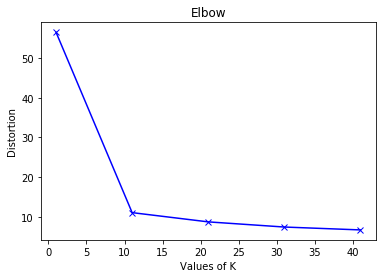

In [164]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {}
mapping2 = {} 
K = range(1,50, 10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(userDetailsNoDuplicates) 
    kmeanModel.fit(userDetailsNoDuplicates)     
      
    distortions.append(sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Elbow') 
plt.show() 

In [175]:
#predict for our data set
numClusters = 10
print(userDetailsNoDuplicates.head())
kmeans =  KMeans(n_clusters=numClusters, random_state=0).fit(userDetailsNoDuplicates)
kmeansResults = kmeans.predict(userDetailsNoDuplicates)
print(kmeansResults)

   age  body_type  height  weight  body_type_weighted
0   28          3    68.0     137                  27
1   36          6    66.0     132                 216
2   34          4    65.0     135                  64
3   27          1    69.0     145                   1
4   45          1    68.0     138                   1
[2 1 7 ... 5 4 8]


In [176]:
#print(pd.DataFrame(kmeansResults))
#userDetailsNoDuplicates.reset_index(inplace=True)
#print(userDetailsNoDuplicates)
userDetailsNoDupsResults =userDetailsNoDuplicates.copy()
userDetailsNoDupsResults['kmeans_cluster'] = pd.DataFrame(kmeansResults)
userDetailsNoDupsResults.head()
# print(len(userDetailsNoDupsResults))
# userDetailsNoDupsResults.head()
#print(userDetailsNoDupsResults)

,age,body_type,height,weight,body_type_weighted,kmeans_cluster
0,28,3,68.0,137,27,2
1,36,6,66.0,132,216,1
2,34,4,65.0,135,64,7
3,27,1,69.0,145,1,8
4,45,1,68.0,138,1,8


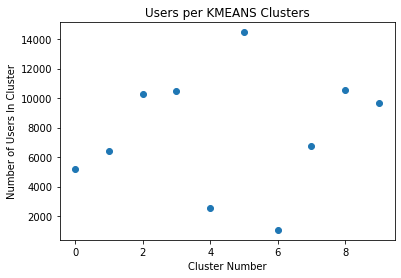

In [167]:
#visualize the clusters
dict = {}

for i, row in userDetailsNoDupsResults.iterrows():    
    dict[row['kmeans_cluster']] = dict.get(row['kmeans_cluster'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:numClusters]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Users In Cluster') 
plt.title('Users per KMEANS Clusters') 
plt.show() 

In [177]:
#merge clusters back
# print(len(userIdsNoDups))
# print(len(userDetailsNoDupsResults))
# print(len(kmeansResults))

# userDetailsNoDupsResults['user_id'] = userIdsNoDups
# dictCols = userDetailsNoDupsResults[['user_id', 'kmeans_cluster']]
# dictCols.set_index('user_id', inplace=True)
# #print(dictCols.info)
# print(dictCols.head())

# print(dictCols.index.is_unique)
# userIdDict = dictCols.to_dict(orient='index')

# permKey = 0

# for key,value in userIdDict.items():
#    print(key, value)
#    permKey = 0
userDetails['kmeans_cluster'] = kmeans.predict(userDetails.drop(columns=['user_id']))
reviews['kmeans_cluster'] = userDetails['kmeans_cluster'].copy()
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,2
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,1
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,7
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,8
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,8


### Post Model Work

* Cluster people by body features, then filter by occassion
* Could look at most common items for a specific occasion
* Come up with a score combining date (recent better), rating, and percentage of users who said item fit

In [178]:
reviewsToFilter = reviews.copy()
reviewsToFilter.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,2
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,1
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,7
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,8
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,8


In [191]:
#this corresponds to rented_for
userOccasion = 6

reviewsByOccasion = reviewsToFilter[reviewsToFilter['rented_for'] == userOccasion]
reviewsByOccasion.reset_index(drop=True, inplace=True)
print('Number of occasion instances: ' + str(len(reviewsByOccasion)))
reviewsByOccasion.head()

Number of occasion instances: 3238


,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,2
1,35,4,16,fit,68.0,909221,10,6,2017-03-28,20,499943,170,480,3,4
2,45,3,16,fit,61.0,1048184,10,6,2017-09-19,8,970594,115,480,3,2
3,36,6,44,fit,69.0,2429745,10,6,2017-03-24,8,434928,125,310,2,1
4,50,3,16,fit,67.0,1261393,10,6,2016-01-22,20,986926,160,480,3,9


In [212]:
# generate most common item categories for occasion
catCounts = reviewsByOccasion['category'].value_counts().to_frame()
catCounts.columns=['count']
catCounts.head()

,count
16,1678
44,263
45,230
32,207
26,171


## Model 2 - Agglomerative Clustering

In [170]:
# from sklearn.cluster import AgglomerativeClustering
# #train Agglormerative Clustering model
# aggResults = AgglomerativeClustering(n_clusters = 20).fit_predict(userDetailsNoDuplicates)

In [171]:
# aggResults = AgglomerativeClustering().fit_predict(userDetailsNoDuplicates)
# userDetailsNoDuplicates['agglormerative_cluster'] = pd.DataFrame(aggResults)
# userDetailsNoDuplicates['user_id'] = userIdsNoDups
# userDetailsNoDuplicates.head()